**A simple ODE system**

Retyped by Theodoret Putra Agatho on 4 Aug. 2023

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.system.html

In [ ]:
pip install deepxde

**Problem Setup**

We will solve a simple ODE system:

\begin{align}
        \frac{dy_{1}}{dt} = y_{2}, \frac{dy_{2}}{dt}, \text{where } t \in [0,10],
    \end{align}

with initial conditions

\begin{align}
        y_{1}(0) = 0, y_{2}(0) = 1.
    \end{align}

The reference solutions is $y_{1} = sin(t), y_{2} = cos(t)$.

**Implementation**

This description goes through the implementation of a solver for the above ODE system step-by-step.

First, the DeepXDE and NumPy(`np`) modules are imported:

In [ ]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining a computational geometry. We can use a built-in class `TimeDomain` to define a time domain as follows

In [ ]:
geom = dde.geometry.TimeDomain(0,10)

Next, we express the ODE system:

In [ ]:
def ode_system(x, y):
  y1, y2 = y[:, 0:1], y[:, 1:]
  dy1_x = dde.grad.jacobian(y, x, i=0)
  dy2_x = dde.grad.jacobian(y, x, i=1)
  return [dy1_x - y2, dy2_x + y1]

The first argument to `ode_system` is the network input, i.e, the $t$-coordinate, and here we represent it as `x`. The second argument to `ode_system` is the network output, which is a 2-dimensional vector where the first component(`y[:, 0:1`) is the $y_{1}$ and the second component (`y[:, 1:]`) is $y_{2}$.

Next, we consider the initial condition. We need to implement a function, which should return `True` for points inside the subdomain and `False` for the points outside. In our case, the point $t$ of the initial conditions is $t = 0$. (Note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating points values are equivalent.)

In [ ]:
def boundary(x, on_initial):
  return dde.utils.isclose(x[0], 0)

The argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. To facilitate the implementaton of `boundary`, a boolean `on_initial` is used as the second argument. If the point $t = 0$, then `on_initial` is True, otherwise, `on_initial` is False. Thus, we can also define `boundary` in a simpler way:

In [ ]:
def boundary (_, on_initial):
  return on_initial

The initial conditions are specified using the computational domain, initial function and boundary. The argument `component` refers to if this IC is for the first component or the second component.

In [ ]:
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

Now, we have specified the geometry, ODEs, and initial conditions. To compute the error of our solution, argument `solution=func` is used as the reference solution, and we define it as follows:

In [ ]:
def func(x):
  return np.hstack((np.sin(x), np.cos(x)))

Since `PDE` is also an ODE solver, we then define the ODE problem as

In [ ]:
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

Where, the number 35 is the number of training residual points sampled inside the domain, and the Number 2 is the number of training points sampled on the boundary (the left and right endpoints of the time domain in this case). We use 100 points for testing the ODE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [ ]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the ODE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Compiling model...
Building feed-forward neural network...
'build' took 0.259761 s

'compile' took 1.718590 s



We then train the model for 20000 iterations:

In [ ]:
losshistory, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.26e+00, 2.64e+00, 0.00e+00, 1.00e+00]    [2.32e+00, 2.69e+00, 0.00e+00, 1.00e+00]    [2.52e+00]    
1000      [1.00e-02, 8.75e-03, 3.50e-08, 4.64e-04]    [1.15e-02, 8.67e-03, 3.50e-08, 4.64e-04]    [8.37e-01]    
2000      [7.45e-03, 5.83e-03, 7.13e-07, 2.09e-04]    [8.17e-03, 5.93e-03, 7.13e-07, 2.09e-04]    [7.24e-01]    
3000      [5.84e-03, 4.38e-03, 1.44e-06, 1.24e-04]    [6.01e-03, 4.59e-03, 1.44e-06, 1.24e-04]    [6.17e-01]    
4000      [3.12e-03, 3.25e-03, 5.96e-06, 1.46e-05]    [3.19e-03, 3.22e-03, 5.96e-06, 1.46e-05]    [4.37e-01]    
5000      [2.96e-04, 4.51e-04, 1.15e-07, 3.76e-06]    [3.32e-04, 2.97e-04, 1.15e-07, 3.76e-06]    [1.20e-01]    
6000      [2.05e-05, 3.23e-05, 6.17e-08, 7.81e-10]    [1.97e-05, 2.45e-05, 6.17e-08, 7.81e-10]    [1.72e-02]    
7000      [1.43e-05, 1.44e-05, 1.06e-09, 2.14e-08]    [1.44e-05, 1.30e-05, 1.

We also save and plot the best trained result and loss history.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


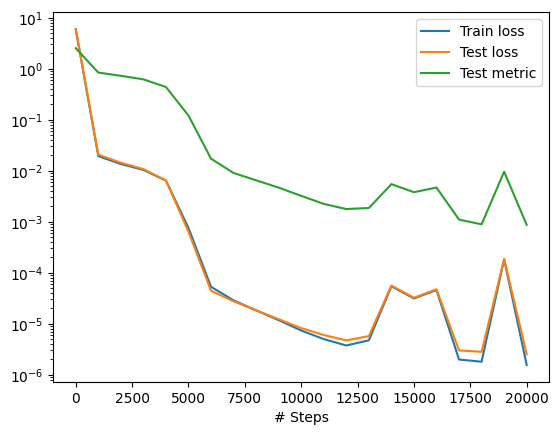

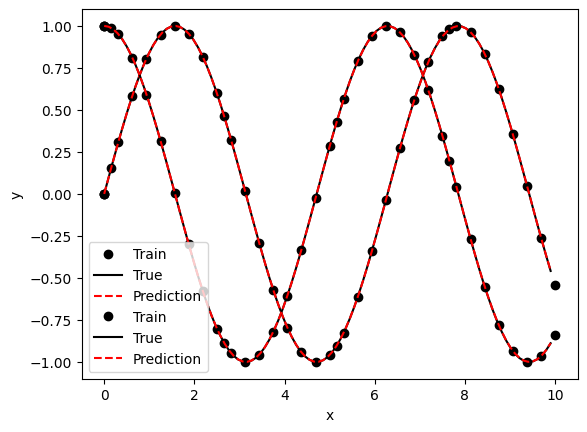

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)